# RLCT Estimation of MNIST

This Jupyter Notebook aims to reproduce the results of Lau et al. (2023) by measuring the Real Log Canonical Threshold (RLCT) for a small 2-layer ReLU model (about 1M parameters) trained on the MNIST dataset. It uses both Stochastic Gradient Nose-Hoover Thermostat (SGNHT) and Stochastic Gradient Langevin Dynamics (SGLD) as sampling methods.

## Main Steps:

1. **Data Preparation**: Load the MNIST dataset for training and testing.
2. **Model Training**: Train a multi-layer perceptron model using stochastic gradient descent.
3. **Model Evaluation**: Evaluate the model's performance on a test set.
4. **RLCT Estimation**: Use SGNHT and SGLD samplers to estimate RLCT.
5. **Plotting**: Visualize train and test losses, and RLCT estimates.

In [ ]:
!pip install devinterp pydantic seaborn wandb tqdm

In [1]:
import copy
import matplotlib.pyplot as plt
import sys

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

sys.path.insert(1, "/home/paperspace/devinterp")  # TODO fix path

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("muted")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("pastel")[:3]

In [2]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)


# Define the neural network
class Net(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

In [3]:
DEVICE = "cuda"
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST(
    "./data", train=True, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_data))
# Load test data
test_data = datasets.MNIST("./data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize model, loss, optimizer and sgld sampler
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
n_epochs = 20

60000


In [4]:
# train model
train_losses = []
test_losses = []
rlct_estimates = []
models = []
for epoch in range(n_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss = evaluate(model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    # rlct_estimates.append(rlct_estimate)
    models += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")

100%|██████████| 118/118 [00:09<00:00, 12.81it/s]


Epoch 1, Train Loss: 1.9797090564743947, Test Loss: 1.2593935072422027


100%|██████████| 118/118 [00:08<00:00, 13.44it/s]


Epoch 2, Train Loss: 0.7703131288290024, Test Loss: 0.5168933182954788


100%|██████████| 118/118 [00:08<00:00, 13.19it/s]


Epoch 3, Train Loss: 0.4590490036091562, Test Loss: 0.3942414440214634


100%|██████████| 118/118 [00:08<00:00, 13.39it/s]


Epoch 4, Train Loss: 0.3793781824031119, Test Loss: 0.34596002027392386


100%|██████████| 118/118 [00:08<00:00, 13.12it/s]


Epoch 5, Train Loss: 0.342110355526714, Test Loss: 0.31863952800631523


100%|██████████| 118/118 [00:08<00:00, 13.55it/s]


Epoch 6, Train Loss: 0.31745082821886417, Test Loss: 0.29936069548130034


100%|██████████| 118/118 [00:08<00:00, 13.35it/s]


Epoch 7, Train Loss: 0.2972498864440595, Test Loss: 0.2840582296252251


100%|██████████| 118/118 [00:08<00:00, 13.31it/s]


Epoch 8, Train Loss: 0.28204420878220415, Test Loss: 0.2711625199764967


100%|██████████| 118/118 [00:08<00:00, 13.38it/s]


Epoch 9, Train Loss: 0.2691761515403198, Test Loss: 0.2593308832496405


100%|██████████| 118/118 [00:08<00:00, 13.45it/s]


Epoch 10, Train Loss: 0.25547573469200374, Test Loss: 0.24785419628024102


100%|██████████| 118/118 [00:08<00:00, 13.25it/s]


Epoch 11, Train Loss: 0.24504778660454993, Test Loss: 0.23769749850034713


100%|██████████| 118/118 [00:08<00:00, 13.24it/s]


Epoch 12, Train Loss: 0.23440726657034988, Test Loss: 0.2287828240543604


100%|██████████| 118/118 [00:08<00:00, 13.53it/s]


Epoch 13, Train Loss: 0.2238590265229597, Test Loss: 0.2218688167631626


100%|██████████| 118/118 [00:08<00:00, 13.50it/s]


Epoch 14, Train Loss: 0.2156385608901412, Test Loss: 0.21289095804095268


100%|██████████| 118/118 [00:08<00:00, 13.36it/s]


Epoch 15, Train Loss: 0.20559073706804695, Test Loss: 0.2039803232997656


100%|██████████| 118/118 [00:08<00:00, 13.30it/s]


Epoch 16, Train Loss: 0.1976738164232949, Test Loss: 0.1970057487487793


100%|██████████| 118/118 [00:08<00:00, 13.30it/s]


Epoch 17, Train Loss: 0.19124657566011963, Test Loss: 0.19109472446143627


100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch 18, Train Loss: 0.18286241357356814, Test Loss: 0.18343290351331235


100%|██████████| 118/118 [00:08<00:00, 13.27it/s]


Epoch 19, Train Loss: 0.17632739511081727, Test Loss: 0.17833250537514686


100%|██████████| 118/118 [00:08<00:00, 13.18it/s]


Epoch 20, Train Loss: 0.16939394245460881, Test Loss: 0.171290148422122


In [5]:
from devinterp.slt.sampler import estimate_rlct

# Load MNIST data
batch_size = 512
train_data = datasets.MNIST(
    "./data", train=True, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Load test data
test_data = datasets.MNIST("./data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models:
    rlct_estimate_sgnht = estimate_rlct(
        model,
        train_loader,
        criterion=criterion,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_rlct(
        model,
        train_loader,
        criterion=criterion,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

Chain 0:   0%|          | 0/400 [00:00<?, ?it/s]

Chain 0: 100%|██████████| 400/400 [00:11<00:00, 35.69it/s] 


-3751.1507123738857 -3631.5400902342076


Chain 0: 100%|██████████| 400/400 [00:10<00:00, 36.93it/s] 


-346.57450471218544 -394.1218129057804


Chain 0: 100%|██████████| 400/400 [00:10<00:00, 37.99it/s] 


45.354720551051116 392.9662923820921


Chain 0: 100%|██████████| 400/400 [00:11<00:00, 35.82it/s] 


17.243422015396373 379.1561167271905


Chain 0: 100%|██████████| 400/400 [00:10<00:00, 36.51it/s] 


52.115434136514956 -262.0582604071222


Chain 0: 100%|██████████| 400/400 [00:11<00:00, 36.04it/s] 


81.42651745060688 130.07862247684795


Chain 0: 100%|██████████| 400/400 [00:11<00:00, 36.28it/s] 


478.05564034452414 -79.085668121085


Chain 0: 100%|██████████| 400/400 [00:10<00:00, 36.45it/s] 


286.8169690918572 364.8548920638427


Chain 0: 100%|██████████| 400/400 [00:11<00:00, 36.25it/s] 


215.44559150558814 142.26234153097323


Chain 0: 100%|██████████| 400/400 [00:10<00:00, 36.63it/s] 


203.53782152026494 374.1688941467428


Chain 0: 100%|██████████| 400/400 [00:11<00:00, 36.03it/s] 


77.79906685295497 80.14842955495348


Chain 0: 100%|██████████| 400/400 [00:10<00:00, 36.66it/s] 


758.9741222109 427.4054993145647


Chain 0: 100%|██████████| 400/400 [00:10<00:00, 36.53it/s] 


536.3282373954997 329.12716360559426


Chain 0: 100%|██████████| 400/400 [00:11<00:00, 35.69it/s] 


-14.460165396363719 329.0867859832012


Chain 0: 100%|██████████| 400/400 [00:10<00:00, 36.40it/s] 


5.858782262109064 238.59280827196258


Chain 0: 100%|██████████| 400/400 [00:10<00:00, 36.77it/s] 


444.44702976429556 594.2232076134297


Chain 0: 100%|██████████| 400/400 [00:10<00:00, 36.60it/s] 


575.365201398502 457.6114608854972


Chain 0: 100%|██████████| 400/400 [00:10<00:00, 36.60it/s] 


557.8371396857125 533.5310289426014


Chain 0: 100%|██████████| 400/400 [00:11<00:00, 36.33it/s] 


361.9376836592082 653.9004521054121


Chain 0: 100%|██████████| 400/400 [00:10<00:00, 36.89it/s] 

575.5876719419753 446.46839135217374


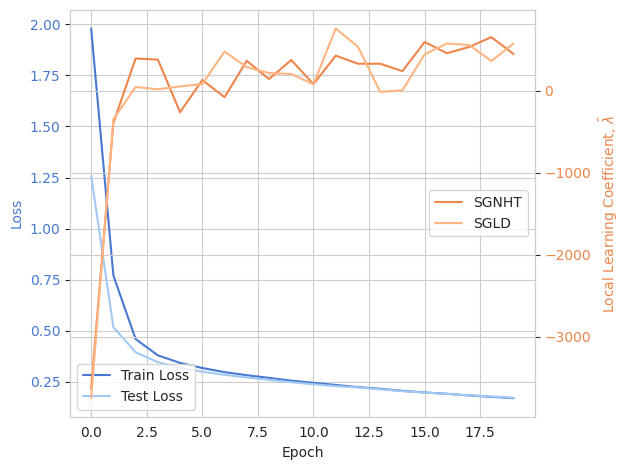

In [13]:
sns.set_style("whitegrid")

fig, ax1 = plt.subplots()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=PRIMARY)
ax1.plot(train_losses, label="Train Loss", color=PRIMARY)
ax1.plot(test_losses, label="Test Loss", color=PRIMARY_LIGHT)
ax1.tick_params(axis="y", labelcolor=PRIMARY)
ax1.legend(loc="lower left")

ax2 = ax1.twinx()
ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
ax2.plot(rlct_estimates_sgnht, label="SGNHT", color=SECONDARY)
ax2.plot(rlct_estimates_sgld, label="SGLD", color=SECONDARY_LIGHT)
ax2.tick_params(axis="y", labelcolor=SECONDARY)
ax2.legend(loc="center right")

fig.tight_layout()
plt.show()